# Growing a Family Hotel Business with Data Science

# Casa Kessler Barcelona

Casa Kessler BCN wants to increase revenue by offering additional products to customers to improve their journey by harnessing essential touchpoints. My job is to use Foursquare to find the most exciting venues to visit in Barcelona, group them in tours, and then apply machine learning to anticipate future customers preference for theses tours based on the data from previous customers.

In [2]:
# First, I import necessary libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')




Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  48.58 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  28.33 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  37.91 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  42.98 MB/s
Libraries imported.


I will use Foursquare to explore Barcelona and find all venues to decide, toghether with the business owners about the tours they will offer

In [4]:
#initializing Foursquarecredentials

CLIENT_ID = 'YIQJW1Z1QKNDA31QQJXLXX40CNMY3UEZQV3TG4MTWBXTRHZZ' # your Foursquare ID
CLIENT_SECRET = 'H4QD52ATEFVNLIK3MLRPL1XILQUD3G3ZLMPT3EBLCOG0I1BQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YIQJW1Z1QKNDA31QQJXLXX40CNMY3UEZQV3TG4MTWBXTRHZZ
CLIENT_SECRET:H4QD52ATEFVNLIK3MLRPL1XILQUD3G3ZLMPT3EBLCOG0I1BQ


Below is the uri for explore Barcelona t get 500 locations on a radus of 30km

In [6]:
lat = 41.390205
lng = 2.154007

limit = 500
radius = 30000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
results = requests.get(url).json()

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
#Finally, getting the list of venues with category and lat,long
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roast Club Café,Coffee Shop,41.387238,2.156027
1,Parking Pizza,Pizza Place,41.393940,2.151295
2,Tandem,Cocktail Bar,41.389533,2.157835
3,La Central,Bookstore,41.392307,2.159686
4,Porvenir,Spanish Restaurant,41.387592,2.153519


Based on what we obtained from Foursquare we make a list with the venues grouped by category and sorted descending by the frequency of the category

In [9]:

bcn_venues = nearby_venues.groupby('categories').count()
bcn_venues.sort_values(by=['name'], ascending=False)


,name,lat,lng
categories,,,
Tapas Restaurant,11,11,11
Hotel,9,9,9
Spanish Restaurant,7,7,7
Coffee Shop,6,6,6
Cocktail Bar,4,4,4
Plaza,4,4,4
Mediterranean Restaurant,4,4,4
Wine Bar,4,4,4
Bookstore,4,4,4


After a brainstorming and analyzing the data from the Foursquare, the management team of the hotel decided to offer 4 tours:
1. Outdoor: Park, Plaza, Market
2. Cultural with: Museum, Church, Cultural Center, Historic Site
3. Tapas & Wine with: Tapas Restaurants & Wine Bars
4. Walk & Shop: Stores, Neighborhood, Road


# Data requirements, collection, visualization & preparation

They started by offering the tours and letting the customers decide. After 3 months, they use data from previous clients to anticipate the preference of future clients. This helps them both in offering a better customer experience to the customers and also for organizing internal resources in time.

In [14]:
# The code was removed by Watson Studio for sharing.

,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type,Tourpref
0,1,34,M,Mon,2,1,Spain,1,NaN,Tourist,NaN
1,2,76,M,Mon,1,1,France,2,NaN,Tourist,Tapas&Wine
2,3,24,F,Wed,2,2,Spain,1,NaN,Tourist,NaN
3,4,47,F,Fri,2,1,Germany,2,NaN,Tourist,Tapas&Wine
4,5,51,M,Tue,3,2,Hungary,3,NaN,Tourist,Cultural


In [15]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
tour_vis = customers_df
tour_vis = tour_vis.groupby('Tourpref').count()
tour_vis

,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type
Tourpref,,,,,,,,,,
Cultural,22,22,22,22,22,22,22,22,5,22
Outdoor,8,8,8,8,8,8,8,8,2,8
Tapas&Wine,26,26,26,26,26,26,26,26,8,26
Walk&Shop,4,4,4,4,4,4,4,4,2,4


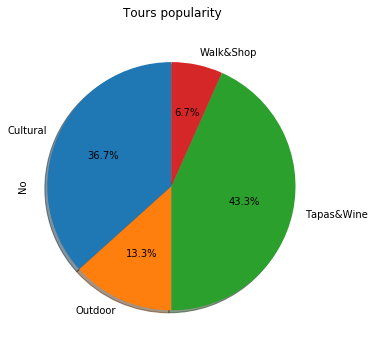

In [17]:
#Visualizing which tour were prefered most
tour_vis['No'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,    
                            )

plt.title('Tours popularity')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

Cleaning data by replacing cathegorical data with numbers

In [18]:
customers_df['Gender'].replace(to_replace=['M','F'], value=[0,1],inplace=True)
customers_df['Travel Type'].replace(to_replace=['Tourist','Business'], value=[0,1],inplace=True)

customers_df['Tourpref'].replace(to_replace=['Outdoor','Cultural', 'Tapas&Wine','Walk&Shop'], value=[1,2,3,4],inplace=True)

customers_df['Entering Day of Week'].replace(to_replace=['Mon','Tue', 'Wed','Thu','Fri','Sat','Sun'], value=[1,2,3,4,5,6,7],inplace=True)

customers_df['Returning times'].fillna(0, inplace=True)

customers_df['Tourpref'].fillna(0, inplace=True)

customers_df.head()


,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type,Tourpref
0,1,34,0,1,2,1,Spain,1,0.0,0,0.0
1,2,76,0,1,1,1,France,2,0.0,0,3.0
2,3,24,1,3,2,2,Spain,1,0.0,0,0.0
3,4,47,1,5,2,1,Germany,2,0.0,0,3.0
4,5,51,0,2,3,2,Hungary,3,0.0,0,2.0


We will visualize The target variable 'Tourpref' related to each feature to decide whch features influence the option

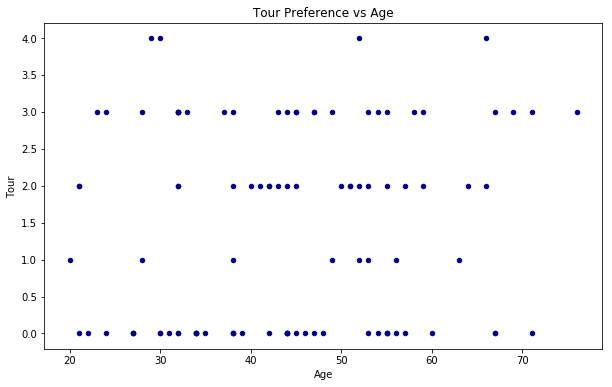

In [19]:
customers_df.plot(kind='scatter', x='Age', y='Tourpref', figsize=(10, 6), color='darkblue')

plt.title('Tour Preference vs Age')
plt.xlabel('Age')
plt.ylabel('Tour')

plt.show()

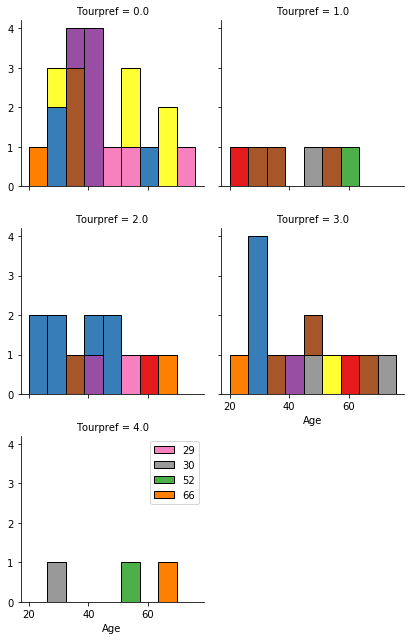

In [20]:
import seaborn as sns

bins = np.linspace(customers_df.Age.min(), customers_df.Age.max(), 10)
g = sns.FacetGrid(customers_df, col="Tourpref", hue="Age", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

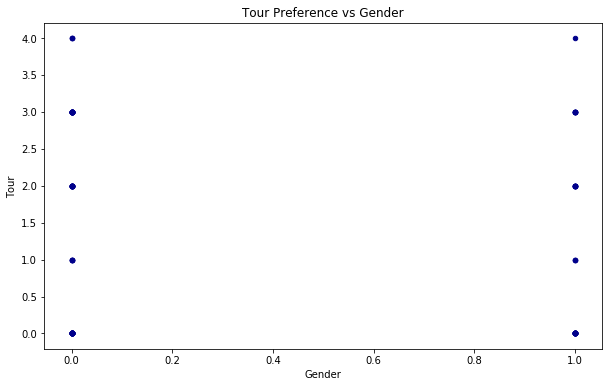

In [21]:
customers_df.plot(kind='scatter', x='Gender', y='Tourpref', figsize=(10, 6), color='darkblue')

plt.title('Tour Preference vs Gender')
plt.xlabel('Gender')
plt.ylabel('Tour')

plt.show()

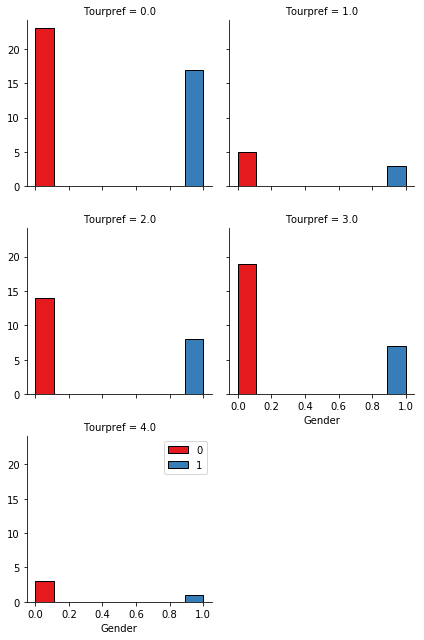

In [22]:
bins = np.linspace(customers_df.Gender.min(), customers_df.Gender.max(), 10)
g = sns.FacetGrid(customers_df, col="Tourpref", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Gender', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

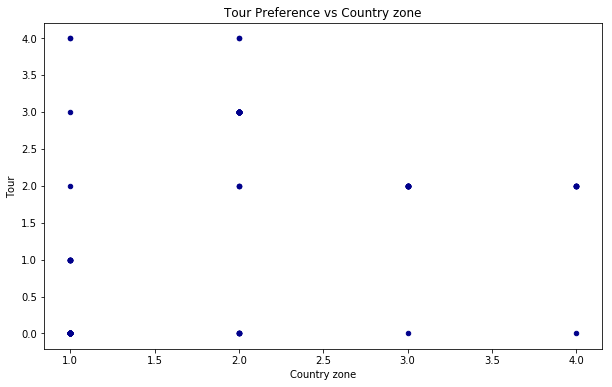

In [23]:
customers_df.plot(kind='scatter', x='Country Code', y='Tourpref', figsize=(10, 6), color='darkblue')

plt.title('Tour Preference vs Country zone')
plt.xlabel('Country zone')
plt.ylabel('Tour')

plt.show()

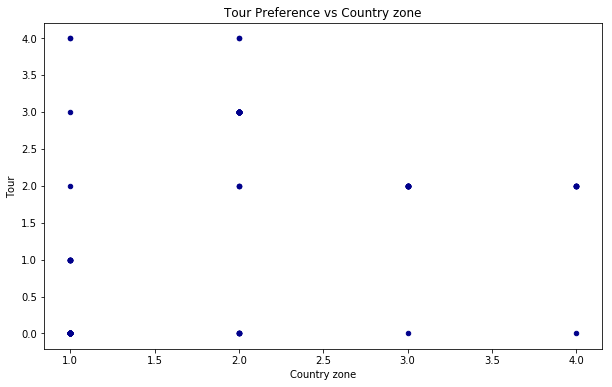

In [24]:
customers_df.plot(kind='scatter', x='Country Code', y='Tourpref', figsize=(10, 6), color='darkblue')

plt.title('Tour Preference vs Country zone')
plt.xlabel('Country zone')
plt.ylabel('Tour')

plt.show()

After above visualisation we decide that Gender is not influential for the Tourpref so we will not use t in our model.

In [26]:
Feature = customers_df[['Age','Entering Day of Week','Staying days','Country Code','Returning times','Travel Type']]


In [27]:
X = Feature
X[0:5]

,Age,Entering Day of Week,Staying days,Country Code,Returning times,Travel Type
0,34,1,2,1,0.0,0
1,76,1,1,2,0.0,0
2,24,3,2,1,0.0,0
3,47,5,2,2,0.0,0
4,51,2,3,3,0.0,0


In [28]:
#Toupref is the target
y = customers_df['Tourpref'].values
y[0:5]

array([ 0.,  3.,  0.,  3.,  2.])

Data normalization

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [31]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.75546748, -1.58310773, -0.22071357, -0.90875888, -0.59524716,
        -0.63910148],
       [ 2.38919398, -1.58310773, -1.14035343,  0.17309693, -0.59524716,
        -0.63910148],
       [-1.5041964 , -0.44826348, -0.22071357, -0.90875888, -0.59524716,
        -0.63910148],
       [ 0.21788012,  0.68658077, -0.22071357,  0.17309693, -0.59524716,
        -0.63910148],
       [ 0.51737168, -1.0156856 ,  0.6989263 ,  1.25495273, -0.59524716,
        -0.63910148]])

To decide which is the proper k we will split the available data into 2 sets: train and test. then, we will see which k ofeers the best accuracy.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (80, 6) (80,)
Test set: (20, 6) (20,)


In [34]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.6 ,  0.45,  0.5 ,  0.55,  0.55,  0.55,  0.55,  0.5 ,  0.55])

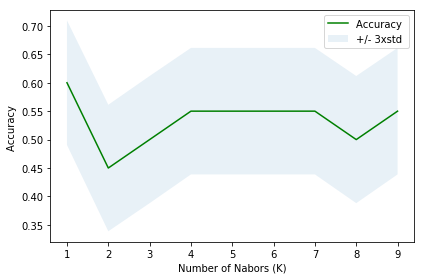

In [35]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [39]:
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was 0.6 with k= 1


In [41]:
#obtaining the accuracy for the test set
k = 1
knn1 = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
knn1
yhat = knn1.predict(X)
print('KNN for k=1 set Accuracy: ', metrics.accuracy_score(y, yhat))

KNN for k=1 set Accuracy:  0.91


Now, it's time to make the first prediction for the next 5 customers who already made reservations

In [42]:

body = client_cb0fed68b7af4d58b25fa61972290699.get_object(Bucket='capstoneproject-donotdelete-pr-0mtjkqzbydnzet',Key='new casa kessler - data - New_customers.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

new_customers_df = pd.read_csv(body)
new_customers_df.head()



,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type,Tourpref
0,1,44,M,Mon,2,1,Spain,1,NaN,Tourist,NaN
1,2,22,F,Mon,1,1,France,2,NaN,Tourist,NaN
2,3,31,F,Mon,2,2,Spain,1,1.0,Business,NaN
3,4,50,M,Tue,3,1,Germany,2,NaN,Tourist,NaN
4,5,55,M,Tue,2,2,Hungary,3,NaN,Tourist,NaN


In [43]:
#Cleaning the data like we did above
new_customers_df['Gender'].replace(to_replace=['M','F'], value=[0,1],inplace=True)
new_customers_df['Travel Type'].replace(to_replace=['Tourist','Business'], value=[0,1],inplace=True)

#new_customers_df['Tourpref'].replace(to_replace=['Outdoor','Cultural', 'Tapas&Wine','Walk&Shop'], value=[1,2,3,4],inplace=True)

new_customers_df['Entering Day of Week'].replace(to_replace=['Mon','Tue', 'Wed','Thu','Fri','Sat','Sun'], value=[1,2,3,4,5,6,7],inplace=True)

new_customers_df['Returning times'].fillna(0, inplace=True)

new_customers_df['Tourpref'].fillna(0, inplace=True)

new_customers_df.head(10)

,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type,Tourpref
0,1,44,0,1,2,1,Spain,1,0.0,0,0.0
1,2,22,1,1,1,1,France,2,0.0,0,0.0
2,3,31,1,1,2,2,Spain,1,1.0,1,0.0
3,4,50,0,2,3,1,Germany,2,0.0,0,0.0
4,5,55,0,2,2,2,Hungary,3,0.0,0,0.0


In [44]:
X_new = new_customers_df[['Age','Entering Day of Week','Staying days','Country Code','Returning times','Travel Type']]

In [45]:
#normalizing new data
X_new= preprocessing.StandardScaler().fit(X_new).transform(X_new)
X[0:5]

array([[-0.75546748, -1.58310773, -0.22071357, -0.90875888, -0.59524716,
        -0.63910148],
       [ 2.38919398, -1.58310773, -1.14035343,  0.17309693, -0.59524716,
        -0.63910148],
       [-1.5041964 , -0.44826348, -0.22071357, -0.90875888, -0.59524716,
        -0.63910148],
       [ 0.21788012,  0.68658077, -0.22071357,  0.17309693, -0.59524716,
        -0.63910148],
       [ 0.51737168, -1.0156856 ,  0.6989263 ,  1.25495273, -0.59524716,
        -0.63910148]])

In [46]:
#getting first predictions
y_new_predict = knn1.predict(X_new)
y_new_predict

array([ 0.,  2.,  0.,  3.,  2.])

In [50]:
new_customers_df['Tourpref']=y_new_predict

we will finally get the dataframe for the new customers with their estimated preference

In [51]:
new_customers_df['Tourpref'].replace(to_replace=[1,2,3,4], value=['Outdoor','Cultural', 'Tapas&Wine','Walk&Shop'],inplace=True)

In [52]:
new_customers_df

,No,Age,Gender,Entering Day of Week,Staying days,Number of persons,Country,Country Code,Returning times,Travel Type,Tourpref
0,1,44,0,1,2,1,Spain,1,0.0,0,0
1,2,22,1,1,1,1,France,2,0.0,0,Cultural
2,3,31,1,1,2,2,Spain,1,1.0,1,0
3,4,50,0,2,3,1,Germany,2,0.0,0,Tapas&Wine
4,5,55,0,2,2,2,Hungary,3,0.0,0,Cultural


# Thank you!